In [33]:
import sys
# setting path
sys.path.append('..')

In [34]:
import numpy as np

from src import inout, var, utils, fourier, lin_reg, reconstruction
from vis import plotter

import importlib
importlib.reload(inout)
importlib.reload(var)
importlib.reload(utils)
importlib.reload(fourier)
importlib.reload(lin_reg)
importlib.reload(reconstruction)
importlib.reload(plotter)

<module 'vis.plotter' from '/home/ray/git-projects/spec_appx/notebooks/../vis/plotter.py'>

In [20]:
grid = var.grid()
cell = var.topo_cell()
    
writer = inout.writer()
fn = '../data/icon_grid_0012_R02B04_G_linked.nc'
writer.read_dat(fn, grid)
grid.apply_f(utils.rad2deg)

lat_ref = 43
lon_ref = 42
vid = utils.pick_cell(lat_ref, lon_ref, grid)

lat_v = grid.clat_vertices[vid,:]
lon_v = grid.clon_vertices[vid,:]

Nx, Ny = 480, 480

cell.lat = np.linspace(lat_v.min(), lat_v.max(), Nx)
cell.lon = np.linspace(lon_v.min(), lon_v.max(), Ny)

cell.gen_mgrids()
cell.topo = np.cos(cell.lon_grid)

# define triangle given the vertices
triangle = utils.triangle(lon_v, lat_v)
cell.get_masked(triangle)

In [41]:
nhi = 12
nhj = 12

fobj = fourier.f_trans(nhi,nhj)
fobj.do_full(cell)
a_m, data_recons = lin_reg.do(fobj, cell, lmbda = 0.2)

fobj.get_freq_grid(a_m)
dat_2D = reconstruction.recon_2D(data_recons, cell)

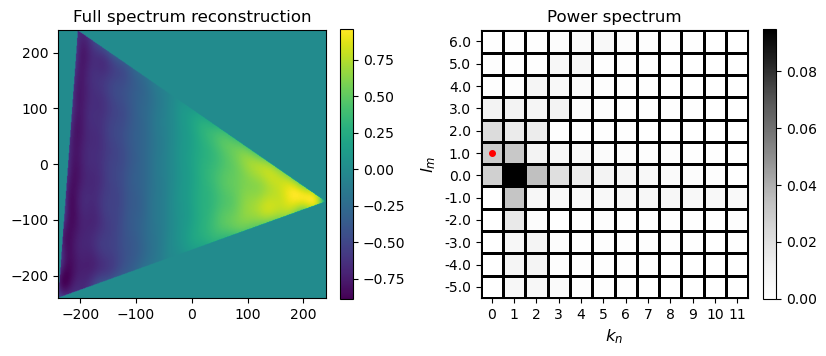

In [42]:
import matplotlib.pyplot as plt

fs = (10,5)
fig, axs = plt.subplots(1,2, figsize=fs)
fig_obj = plotter.fig_obj(fig, nhi, nhj)
axs[0] = fig_obj.phys_panel(axs[0], dat_2D)
axs[1] = fig_obj.freq_panel(axs[1], fobj.ampls)